In [1]:
from ase.io import read, write 
from ase import atoms 
from ase.io.vasp import read_vasp
from ase.visualize import view
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
import random
import numpy as np
from ase.md import MDLogger
from ase.md.npt import NPT
from ase import units
from mace.calculators import mace_mp, MACECalculator
from tqdm import tqdm
from ase.md.analysis import DiffusionCoefficient
import os
import matplotlib.pyplot as plt

In [2]:
import utils.diff_coeff as diff

# About the notebook
In this notebook, you will get a small introduction into how you can launch and use the MACE-MP-0 calculator to run Nose-Hoover NVT Molecular Dynamics.

# 1.1) Atoms Object
In this first step, lets first begin by visualising the g-Li3PS4 structure

In [8]:
g_li3ps4 = read('g_li3ps4.xyz')
view(g_li3ps4, viewer='ngl')

# 1.2) MACE-MP-0 Calculator
In this next step, we will initialise the MACE-MP0-0 calculator. MACE provides 2 calculators the 'mace_mp' and the MACECalculator, the first is spcecific to launching the MACE-MP-0 models and is what we will be using today. Whit the second calculator any MACE model can be used, this includes the MACE-MP-0 models. In the program you will use later, both are implemented

In [9]:
from mace.calculators import mace_mp, MACECalculator


#MACE-MP-0 calculator parameters

model = 'small' # defines the MACE-MP-0 model that is to be used small, medium or large
device = 'cpu'  # states what to use for calculation cpu or gpu
default_dtype = 'float32' # defines the dtype for the calculation float32 or float64. 
                          # float32 is less accurate but faster



calc = mace_mp(model=model, device=device, default_dtype=default_dtype)

Using Materials Project MACE for MACECalculator with /home/chem/msufwc/.cache/mace/46jrkm3v
Using float32 for MACECalculator, which is faster but less accurate. Recommended for MD. Use float64 for geometry optimization.
Default dtype float32 does not match model dtype float64, converting models to float32.


# 1.3) Nose-Hoover NVT Molecular Dynamics
We can then attach this calculator to our structure and run some NVT MD. In the provided program, only Nose-Hoover NVT is supported and all parameters are representative of this choice. The provided program exploits ASE's Nose-Hoover implementation which is actually an ASE NPT model that has the barostat disabled. The program disables this by default but this can be modified, and NPT dynamics run by modifying the mace_nvt.py file to include a barostat.

In [16]:
g_li3ps4.calc = calc


# NVT molecular dynamics input parameters
temp = 800 # temperature to run the MD at
ts = 2*units.fs # timestep of the MD
tts = 80*units.fs # characteristic timestep of the thermostast, a good value is 40*time step
step = 10 # number of MD steps to simulate




# defines file to save the trajectory, time, and temperature too
temp_arr = []
time_arr = []

def write_frame():
    dyn.atoms.write('test_mace_md.xyz', append=True)
    time_arr.append(dyn.get_time())
    temp_arr.append(dyn.atoms.get_temperature())
## initialise the MD
MaxwellBoltzmannDistribution(g_li3ps4, temperature_K=temp)
dyn = NPT(g_li3ps4, externalstress=1., timestep =ts, ttime=tts, temperature_K=temp)
dyn.attach(write_frame, interval=1)

## run MD
dyn.run(int(step))

f = open('test_mace_md_temp.txt', 'w')

for i in range(len(temp_arr)):
    f.write(str(time_arr[i]) + ' ' + str(temp_arr[i]) + '\n')
f.close()




# 1.4) Diffusion constant
From this MD, we can then extract a diffusion constant. This is done by calculating the Mean Square Displacement and then the gradient of the resulting plot. This value is what we will later plot and calculate

In [18]:
trajectory = read('test_mace_md.xyz', index = ':')
ts = 2*units.fs # timestep of the MD
atom = 'Li' # atom to calculate the diffusion constant for
start = 0 # which frame of the trajectory to start calcualting from, can be used to ignore the initial equilibration
diffusion_coeff = diff.get_diffusion_coeff(trajectory, timestep=ts, atom=atom, start=start)
print('The diffusion coefficient at',temp,'K was:', diffusion_coeff,'cm^2/S')

The diffusion coefficient at 800 K was: 2.369005451245663e-05 cm^2/S


# 2) Diff_Coeff
In this next section, you will use the diff_coeff.py file that is found in utils to run MD using MACE-MP-0. The aim is to run it for multiple temperatures with multiple repeats at each temperature. This will allow us to calculate an average temperature, with errors, and extrapolate to a room temperature diffusion constant, while proppogating the errors.

# 2.1 Basic Script
The first place to start is the diffusion_plot() function found in diff_
This function automates the running, caclculation and extrapolation of dissplacement constants and serves as an example of how to set up the system.

In [16]:
def diffusion_plot(structure_file,temp_arr=[525], repeats=5, ts=2*units.fs, tts=80*units.fs, step=100, atom='Li', start=0, model='medium', floats='float32'):
    #set up and run the md, in this case the paralel cpu implementation
    diff.run_md_bash(structure, temp_arr, repeats, ts, tts, step, model, floats)
    
    #read in the diffusion coefficients from the generated files
    dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)
    
    #plot the diffusion constants and extract the coefficients, covarience 
    coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)
    return coefficients, dict_diff_coeff,cov


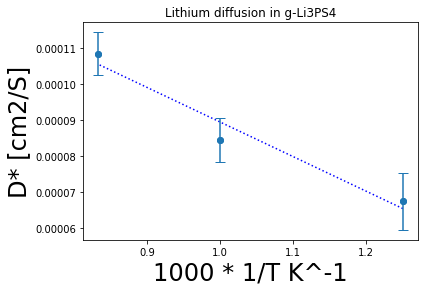

The estimated room temperature difussion coefficient  -0.000133842935341531  +-  4.416738857642066e-05  cm2/s


In [17]:
coefficients,dict_diff_coeff,cov = diff.diffusion_plot(
    structure_file='g_li3ps4.xyz',
    temp_arr=[800,1000,1200], 
    repeats=5, 
    ts=2*units.fs, 
    tts=80*units.fs, 
    step=10, 
    atom='Li', 
    start=0, 
    model='small', 
    floats='float32',
    device='cpu'
    )

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

when defining your diffusion plot function there are some options.
the first of this is how you run the MD
you have an option of run_md_bash or run_md. the run md option will simply run the vairous temperatures and repeats sequentially, this is good for GPUs where the calculations will use the whole GPU and will run faster. run_md_bash works by first making a bash script that attempts to launch all temperature and repeats at the same time. This is well suited to cpu where MACE can only use one core, this in effect allows us to parallelise calculations


following this, we also have a choice in what you wish to plot, the choice here is between plot_average_diff_coeff and plot_diff_coeff. plot_diff_coeff will plot all calculated diffusion constants, and plot_average_diff_coeff will plot the average diffusion constant at a given temperature. Both will calculate a line of best fit and output the coefficients and the covariance matrix.

feel free to play around with some of the parameters but keep in mind that making the models larger will make them more expensive. another consideration for evaluation for evaluation on hetmathsys is that there are only 40 cores available, as such the length of your temperature array * the number of repitions should ideally be below 40 as the runs will be launched at the same time and will each require 1 cpu. In the case that you want to do more than 40 total calculations this is possible by splitting up the calculations like shown below

In [ ]:
structure_file='g_li3ps4.xyz'
repeats=10
ts=2*units.fs
tts=80*units.fs 
step=10
atom='Li'
start=0
model='small'
floats='float32'
device='cpu'



#set up and run the md, in this case the paralel cpu implementation

temp_arr=[100,200,300,400]
diff.run_md_bash(structure_file, temp_arr, repeats, ts, tts, step, model, floats, device)

temp_arr=[500,600,700,800]
diff.run_md_bash(structure_file, temp_arr, repeats, ts, tts, step, model, floats, device)



#read in the diffusion coefficients from the generated files
temp_arr=[100,200,300,400,500,600,700,800]
dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)

#plot the diffusion constants and extract the coefficients, covarience 
coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

you can see above that for the calculations we can give multiple sets of arrays to each run, and combine the temperature arrays when we come to extracting the coefficients. this is because when the MD is run, it is saved to a file name including the temperature and repetition. For this to work you need to ensure number of repitions is consistent in each run. note that running the simulation again will overwrite the saved files.

Finally for the reproducible result, you are welcome to experiment with some parameters, you should do 1 production run at 800K,1000K,1200K and 1400K. using 5 repitions. from this you should plot the graph of the diffusion constants and extract the diffusion constant at 300K compare this to a precalculated value of ----

In [ ]:
coefficients,dict_diff_coeff,cov = diff.diffusion_plot(
    structure_file='g_li3ps4.xyz',
    temp_arr=[800,1000,1200,1400], 
    repeats=5, 
    ts=2*units.fs, 
    tts=80*units.fs, 
    step=10000, 
    atom='Li', 
    start=0, 
    model='medium', 
    floats='float32',
    device='cpu'
    )

room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

In the case that your calculations have already run and you wish to avoid rerunning use the following cells

In [5]:
# same parameters as above
structure_file='g_li3ps4.xyz'
temp_arr=[800,1000,1200,1400]
repeats=5
ts=2*units.fs 
tts=80*units.fs 
step=10000
atom='Li' 
start=0
model='medium' 
floats='float32'
device='cpu'

#read in the diffusion coefficients from the generated files
dict_diff_coeff = diff.extract_diff_coeff(temp_arr, repeats, atom, start, ts)

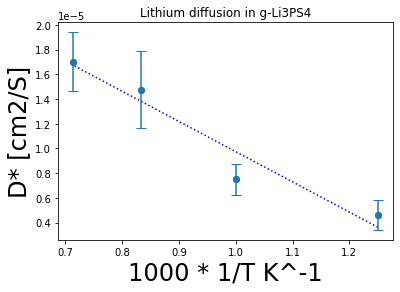

The estimated room temperature difussion coefficient  -4.7295302687762855e-05  +-  9.946630496785827e-06  cm2/s


In [6]:
#plot the diffusion constants and extract the coefficients, covarience
#this plot takes an average value at each temperatue and plots the standard deviation as the error bars
coefficients,cov = diff.plot_average_diff_coeff(dict_diff_coeff)

#extract the room temperature diffusion coefficient
room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

[-2.44422848e-05  3.41789801e-05] [[ 8.62987235e-12 -8.19324191e-12]
 [-8.19324191e-12  8.12750273e-12]]


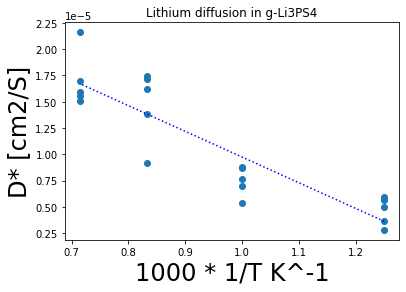

The estimated room temperature difussion coefficient  -4.7295302687762855e-05  +-  9.946630496785827e-06  cm2/s


In [7]:
#plot the diffusion constants and extract the coefficients, covarience
#this plot shows all calcualted diffusion constants
coefficients,cov = diff.plot_diff_coeff(dict_diff_coeff)

#extract the room temperature diffusion coefficient
room_diff_coeff,err = diff.room_temp_diff_coeff(coefficients, cov ,300)
print('The estimated room temperature difussion coefficient ', room_diff_coeff,' +- ',err,' cm2/s')

The estimated room temperature difussion coefficient  -4.7597e-05 cm^2/S  +-  1.0264e-05  cm^2/s


You can see that the error on this is quite high, this could be improved with more repeats, a larger MACE-MP-0 model and longer trajectories. However it also shows MACE-MP-0s main limitation where the training set has no data on structures at non 0K temperatures and as such we do not expect it to perform perfectly.

The experimental value that is quoted is typically on the 10^-7 order of magnitude. While we can see that we are not miles away we are certainly not close to that and MACE-MP-0 predicts higher mobility of the Lithium ions.

Finally, this shows that despite limitations in the data set, it is remarkably stable. It also shows that for accurate results, this foundation model will need to be fine tuned to get more accurate results.